In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

In [13]:
# opening the dataset
parser = Sbopen()
matches_df = parser.match(competition_id=72, season_id=30)
matches_df.head()

team = "England Women's"

# get a list of match ids for the team
def get_match_ids(team):
    match_ids = matches_df.loc[(matches_df['home_team_name'] == team) | (matches_df['away_team_name'] == team)]['match_id'].tolist()
    return match_ids

match_ids = get_match_ids(team)
no_games = len(match_ids)
print(f"Number of games for {team}: {no_games}")
print(match_ids)

Number of games for England Women's: 7
[69301, 22936, 68337, 22962, 68362, 69199, 69258]


In [11]:
df_info = parser.event(69301)[0]
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3289 non-null   object 
 1   index                           3289 non-null   int64  
 2   period                          3289 non-null   int64  
 3   timestamp                       3289 non-null   object 
 4   minute                          3289 non-null   int64  
 5   second                          3289 non-null   int64  
 6   possession                      3289 non-null   int64  
 7   duration                        2457 non-null   float64
 8   match_id                        3289 non-null   int64  
 9   type_id                         3289 non-null   int64  
 10  type_name                       3289 non-null   object 
 11  possession_team_id              3289 non-null   int64  
 12  possession_team_name            32

In [14]:
"""
The context for this heat map is that we'll look at dangerous passes.
Those are passes that lead to a shot within a certain time window.
"""

def dangerous_passes(match_ids, team):
    dangerous_passes_df = pd.DataFrame()

    for match_id in match_ids:
        df = parser.event(match_id)[0]  # event data is at index 0
        for period in [1, 2]:
            # only keep accurate passes that were not set pieces in this period
            pass_mask = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            passes_df = df.loc[pass_mask, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]

            # keep shots in this period
            shot_mask = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            shots_df = df.loc[shot_mask, ["minute", "second"]]

            # create a pandas Series with the pass times converted to seconds
            pass_times = passes_df["minute"] * 60 + passes_df["second"]

            # create a pandas Series with the shot times in seconds (pass window end)
            pass_window_end = shots_df["minute"] * 60 + shots_df["second"]

            # find start of window before shot (for example 15 seconds before)
            shot_window = 15
            pass_window_start = pass_window_end - shot_window

            # condition to avoid negative window start
            pass_window_start = pass_window_start.apply(lambda i: i if i > 0 else (period - 1) * 45)

            # collect passes that are within the pass window
            pass_to_shot = pass_times.apply(lambda x: True in ((x > pass_window_start) & (x < pass_window_end)).unique())

            # get passes from df
            dangerous_passes_period = passes_df.loc[pass_to_shot]

            # add to dangerous passes df
            dangerous_passes_df = pd.concat([dangerous_passes_df, dangerous_passes_period], ignore_index=True)

    return dangerous_passes_df

dangerous_passes_df = dangerous_passes(match_ids, team)
dangerous_passes_df.head()

,x,y,end_x,end_y,minute,second,player_name
0,114.6,16.4,111.3,7.1,22,40,Ellen White
1,32.9,70.0,42.0,68.5,30,26,Stephanie Houghton
2,41.7,71.0,45.1,76.5,30,27,Jill Scott
3,53.9,76.2,67.0,62.0,30,30,Nikita Parris
4,70.4,54.9,85.1,66.2,30,32,Jill Scott


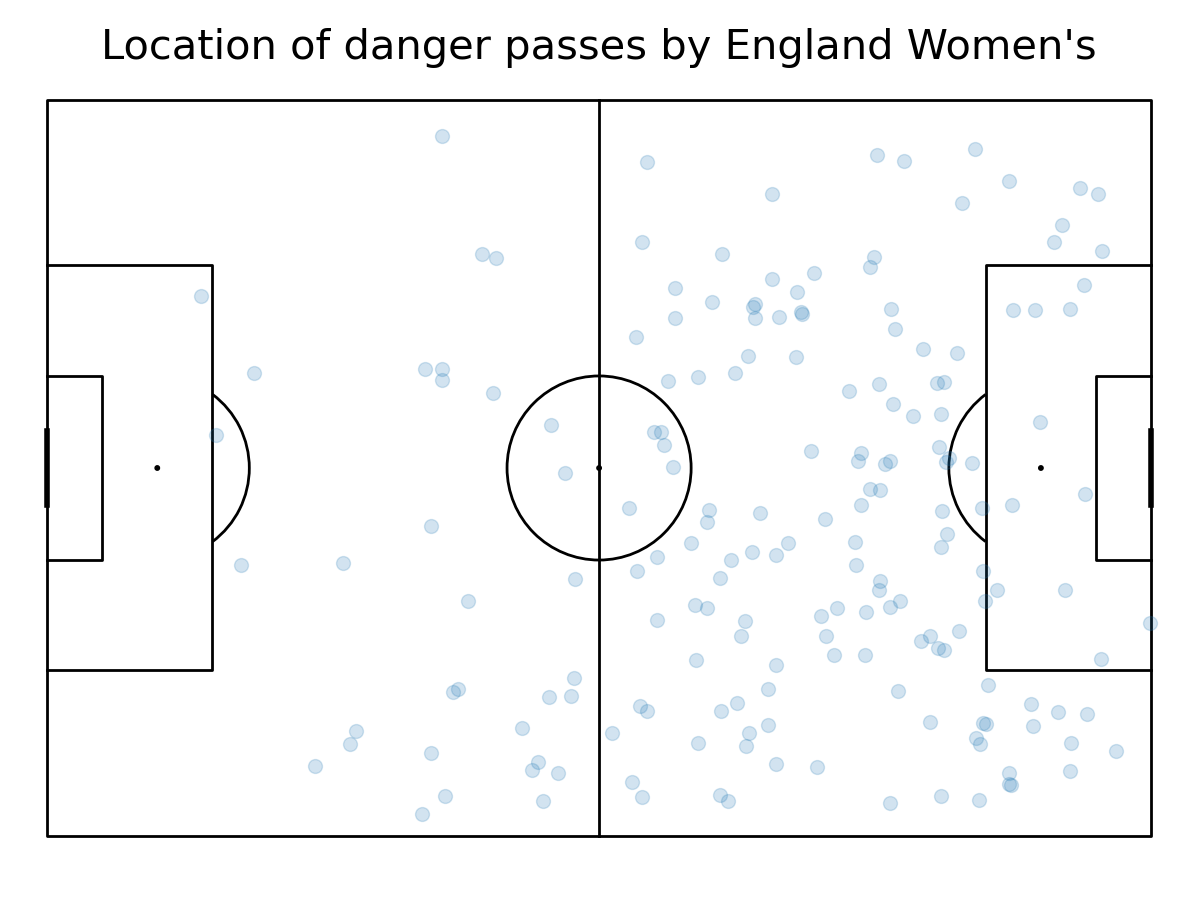

In [4]:
# plot the dangerous passes
pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# scatter the passes
pitch.scatter(dangerous_passes_df['x'], dangerous_passes_df['y'], alpha=0.2, s=100, ax=ax['pitch'])

# plot arrows
#pitch.arrows(dangerous_passes_df['x'], dangerous_passes_df['y'],
#            dangerous_passes_df['end_x'], dangerous_passes_df['end_y'],
#            ax=ax['pitch'], alpha=0.5)

fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()


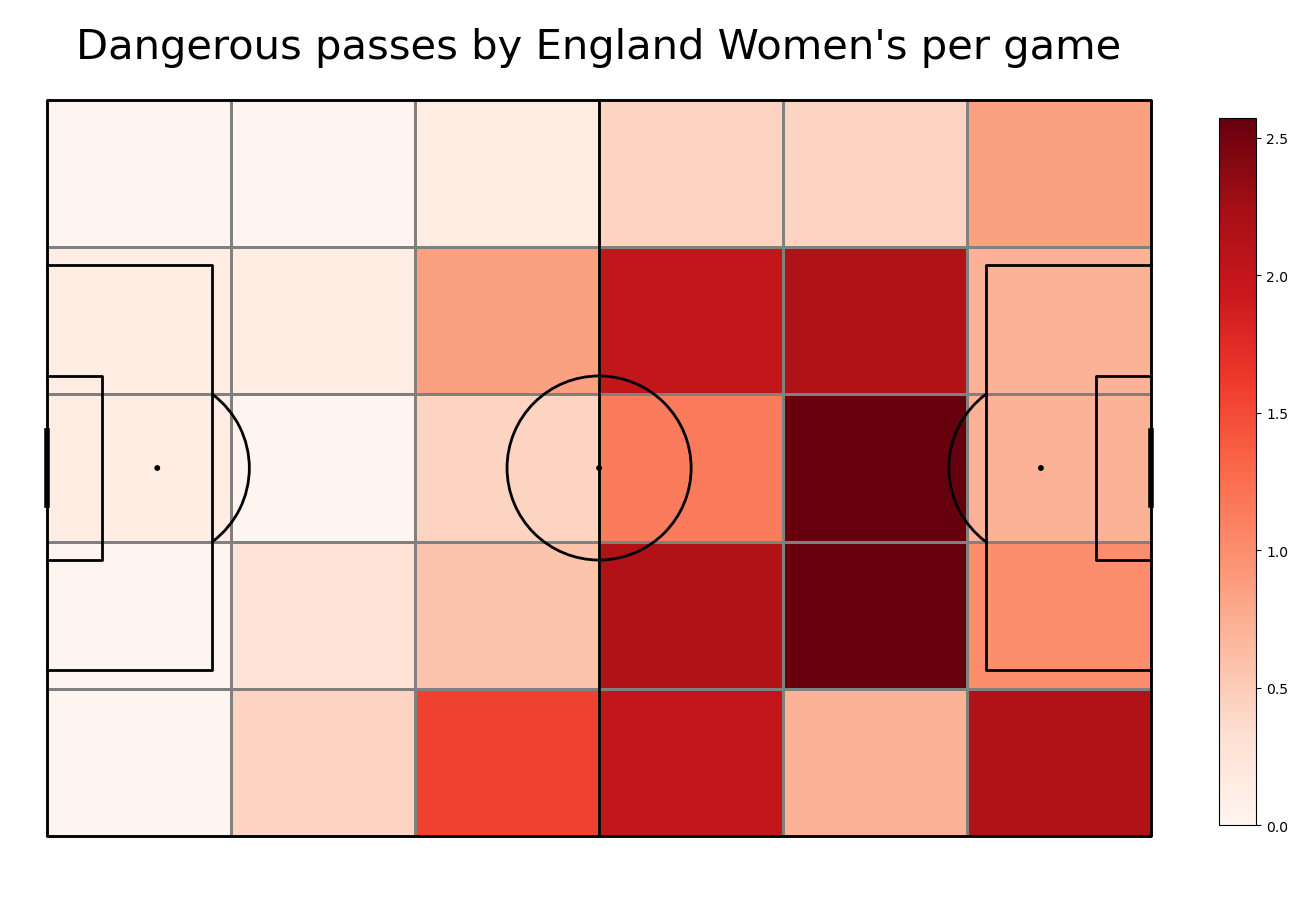

In [5]:
# make the heat map

pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# get the 2D histogram
bin_statistic = pitch.bin_statistic(dangerous_passes_df['x'], dangerous_passes_df['y'], statistic='count', bins=(6, 5), normalize=False)

# normalize by number of games
bin_statistic['statistic'] = bin_statistic['statistic'] / no_games
pcm = pitch.heatmap(bin_statistic, ax=ax['pitch'], cmap='Reds', edgecolor='grey')

# legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Dangerous passes by ' + team + " per game", fontsize = 30)
plt.show()

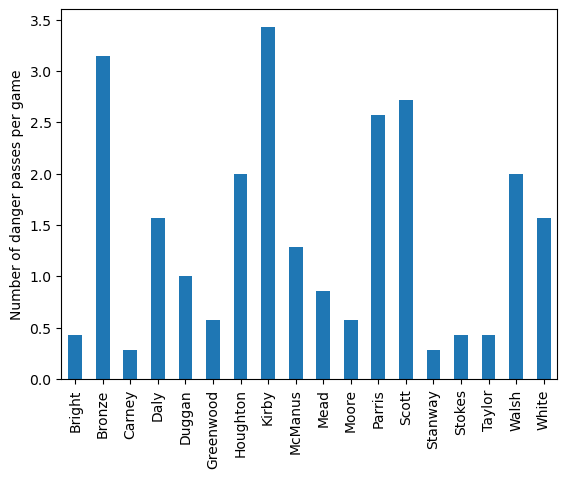

In [8]:
# diagram of most involved players

# only use last names
dangerous_passes_df['player_name'] = dangerous_passes_df['player_name'].str.split().str[-1]

# count passes by player and normalize by number of games
pass_count = dangerous_passes_df.groupby('player_name').size() / no_games

# make a histogram
ax = pass_count.plot.bar(pass_count)

#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()